[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MatteoFalcioni/Learning-LangGraph/blob/main/notebooks/12_hierarchical_agent_teams.ipynb)

### Setup

#### Install requirements

In [51]:
%pip install -q -U -r https://raw.githubusercontent.com/MatteoFalcioni/Learning-LangGraph/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### local (notebooks or files)

In [52]:
from dotenv import load_dotenv
load_dotenv()  # load api keys

True

#### Colab

In [ ]:
from google.colab import userdata
import os

REQUIRED_KEYS = [
    'OPENAI_API_KEY',
    'LANGSMITH_TRACING',
    'LANGSMITH_ENDPOINT',
    'LANGSMITH_API_KEY',
    'LANGSMITH_PROJECT',
    'TAVILY_API_KEY'
]

def _set_colab_keys(key : str):
    # Retrieve the secret value using its key/name
    secret_value = userdata.get(key)
    # set it as a standard OS environment variable
    os.environ[key] = secret_value

for key in REQUIRED_KEYS:
    _set_colab_keys(key)

# Hierarchical Agent Teams

We already introduced the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

> **Note:** We actually took out chart generation from the LangChain tutorial to simplify. 

<center>
    <img src="images/hierarchical_teams.png" width=800>
</center>



## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**ResearchTeam tools**

The research team can use a search engine and url scraper to find information on the web.

In [71]:
from typing import List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [72]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
from langchain.tools import tool, ToolRuntime
from e2b_code_interpreter import Sandbox
from langgraph.types import Command
from typing_extensions import Annotated
from langchain_core.messages import ToolMessage

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [73]:
from typing import Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next and a message explaining your reasoning. "
        " Each worker will perform a task and respond with their results and status. "
        " When finished, respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]
        reasoning: str

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        reasoning = response["reasoning"]

        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto, "messages": HumanMessage(content=reasoning)})

    return supervisor_node

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [74]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [75]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

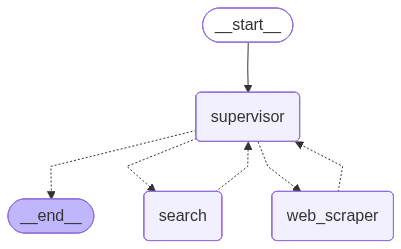

In [76]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [77]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour? We are in 2026 by the way.")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search', 'messages': HumanMessage(content="To determine Taylor Swift's tour dates, we need to search for the most recent and reliable information. The 'search' worker can provide this information by accessing the latest data on Taylor Swift's current tour schedule.", additional_kwargs={}, response_metadata={}, id='9714db8a-66f2-48b2-a632-a542e284bbb5')}}
---
{'search': {'messages': [HumanMessage(content="I couldn't find specific information about Taylor Swift's tour dates for 2026. However, given that Taylor Swift recently completed a record-breaking, nearly two-year world tour, it's possible that she is taking some time away from the spotlight.\n\nFor the most up-to-date information, you might want to check Taylor Swift's official website or major ticketing platforms closer to the date.", additional_kwargs={}, response_metadata={}, name='search', id='63c5206b-aff9-443d-9deb-04d00dfbd5fa')]}}
---
{'supervisor': {'next': '__end__', 'messages': HumanMessage(conte

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [78]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    system_prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_agent(
    llm,
    tools=[create_outline, read_document],
    system_prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker"]
)

With the objects themselves created, we can form the graph.

In [79]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

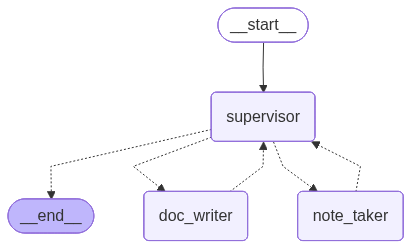

In [80]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [81]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk. Be concise and quick.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker', 'messages': HumanMessage(content='First, we need the note_taker to create an outline for the poem about cats. The outline will provide a structured format that the doc_writer will then use to write and save the poem to disk.', additional_kwargs={}, response_metadata={}, id='f095d7d5-b365-41e3-a9ed-6f273e99b803')}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been created and saved as "cat_poem_outline.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='2974badd-fefd-4bf3-92ae-31c3be2a9ad2')]}}
---
{'supervisor': {'next': 'doc_writer', 'messages': HumanMessage(content="The note_taker has completed the task of creating an outline for the poem about cats. Now, it's the role of the doc_writer to take this outline and craft the actual poem, subsequently writing it to disk.", additional_kwargs={}, response_metadata={}, id='9c09a2c5-febf-4a83-8832-89f450f3a65d')}}
---
{'doc_writer': 

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [82]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [83]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

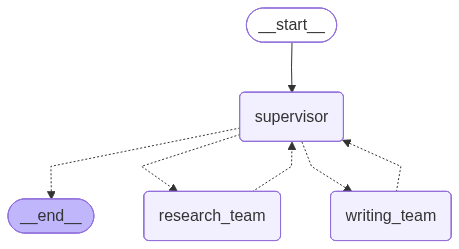

In [84]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

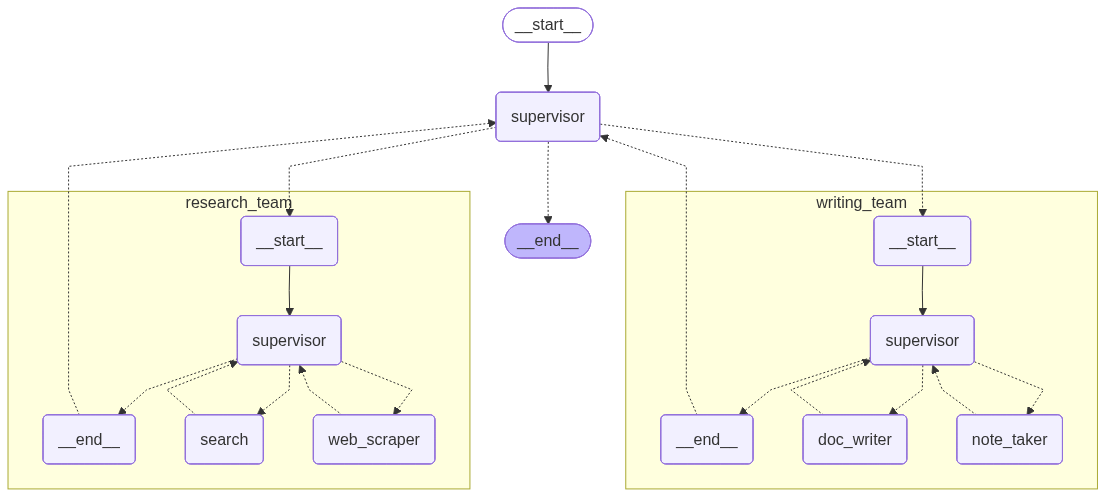

In [85]:
from IPython.display import Image, display

display(Image(super_graph.get_graph(xray=1).draw_mermaid_png()))

In [86]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents (it's the year2026) and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team', 'messages': HumanMessage(content='The first step in this process is to gather information on AI agents as of the year 2026. The research_team is best equipped to handle this task as they can collect the most up-to-date data and insights on the topic, which will be crucial for the writing_team to craft an accurate and informative report.', additional_kwargs={}, response_metadata={}, id='3c6c2b19-089b-475b-8dd6-a764bac5bec6')}}
---
{'research_team': {'messages': [HumanMessage(content="The user request to gather information on AI agents as of the year 2026 involves future data which is beyond the current capabilities of both 'search' and 'web_scraper' workers. The request likely refers to a hypothetical scenario or future-planning task, rather than something that can be actively searched or scraped. Therefore, it would be inappropriate to assign a current task to 'search' or 'web_scraper', as they can only provide data up to the present time, Octob